# Sentiment Prediction based on Drug reviews

##### Team: Gargeyi Baipa , Naveen Donthineni

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
!pip install wget
!pip install wordcloud
from wordcloud import WordCloud
!pip install yellowbrick


In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_spam
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport

##### Import the data file for the analysis

In [2]:
import wget

In [3]:
import re

In [4]:

wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip')

'drugsCom_raw (21).zip'

In [6]:
import zipfile

In [7]:
with zipfile.ZipFile("drugsCom_raw.zip","r")as zip_ref:
    zip_ref.extractall()

In [8]:
dftest = pd.read_csv('drugsComTest_raw.tsv',delimiter = '\t')

In [9]:
dftrain = pd.read_csv('drugsComTrain_raw.tsv',delimiter = '\t')

In [10]:
combine = [dftrain,dftest]
df = pd.concat(combine)

In [157]:
df.head()


,Unnamed: 0,drugName,condition,review,rating,usefulCount,wordcount,charcount,lemmatize,sentiment,subjectivity,class_label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,27,17,79,side effect take combination bystolic mg fish oil,0.000000,0.000000,neutral
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,192,141,741,son halfway fourth week intuniv became concern...,0.188021,0.482812,positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,17,134,755,used take another oral contraceptive 21 pill c...,0.159790,0.367599,positive
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,10,89,448,first time using form birth control glad went ...,0.262500,0.618750,positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,37,124,719,suboxone completely turned life around feel he...,0.163333,0.384359,positive


## Data Cleaning 

In [158]:
df['date'] = pd.to_datetime(df['date'])
dftrain['date'] = pd.to_datetime(dftrain['date'])


KeyError: 'date'

In [159]:
df_drug_review=pd.DataFrame(dftrain)
df_drug_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
Unnamed: 0     161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null float64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


#### There are 161297 records exsists in the dataset and 6 variablea are available

#### Look at the summary stastics of numerical fileds

In [160]:
df_drug_review.describe()[['rating','usefulCount']]

,rating,usefulCount
count,161297.000000,161297.000000
mean,6.994377,28.004755
std,3.272329,36.403742
min,1.000000,0.000000
25%,5.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,1291.000000


##### As we see,mean rating value of all drugs is 6.9 and around average of 28 people found the drug reviews are useful

##### Check the dataset for the missing values

In [162]:
df_drug_review.isnull().values.any()

True

In [163]:
df_drug_review.columns[df_drug_review.isnull().any()].tolist()

['condition']

###### Looks like "condition" attribute is missing the values but rest of the fields are ok

In [164]:
size = df_drug_review.shape[0]

print ("Total Size of the dataset : ", size)

total_na = df_drug_review.isnull().sum(axis = 0)['condition']
print ("Null values : ", total_na)

print ("PERCENTAGE : ", (total_na/size)*100)

Total Size of the dataset :  161297
Null values :  899
PERCENTAGE :  0.5573569254232875


#####  "condition" variable is having missing the values and % of missing values are 0.5%.So we have removed them from the analysis

##### Check for Duplicate values

In [165]:
df_drug_review.duplicated()

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
161267    False
161268    False
161269    False
161270    False
161271    False
161272    False
161273    False
161274    False
161275    False
161276    False
161277    False
161278    False
161279    False
161280    False
161281    False
161282    False
161283    False
161284    False
161285    False
161286    False
161287    False
161288    False
161289    False
161290    False
161291    False
161292    False
161293    False
161294    False
161295    False
161296    False
Length: 161297, dtype: b

####  Convert the all column names into lower case

In [166]:
df_drug_review.columns=df_drug_review.columns.str.lower()

#### How many unique drugs and conditions exsists in the dataset?

In [167]:
##number of unique drugs present in the dataset
df_drug_review['drugname'].nunique()

3436

In [168]:
##number of unique conditions present in the dataset
df_drug_review['condition'].nunique()

884

#### There are 3431 drugs and 884 unique health conditions exsists in the dataset 

### Exploratory Data Analysis (EDA)

##### Let us analyse the drugs attribute

#### What are Top 10 drugs in the dataset?

Text(0.5, 1, 'Top 10 rating - Drugs')

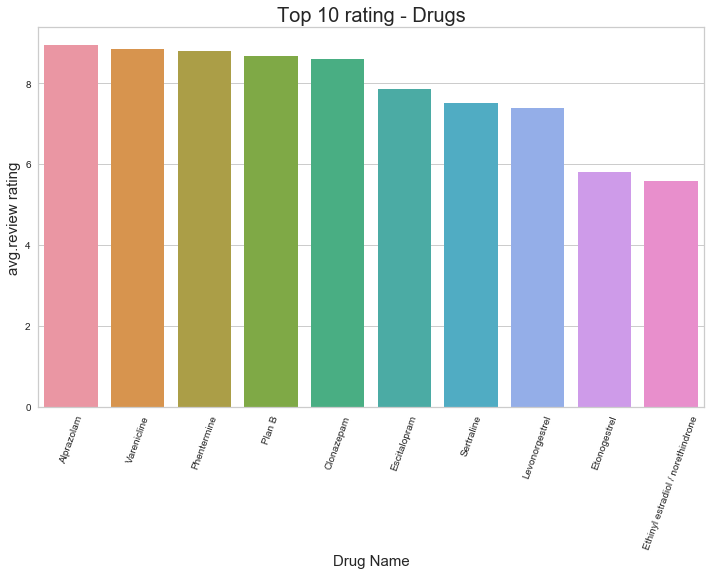

In [169]:
##Find list of drugs which are having rating 10
df_drug_review_10 = dict(df_drug_review.loc[df_drug_review.rating == 10, "drugname"].value_counts())
drugname = list(df_drug_review_10.keys())
drug_rating = list(df_drug_review_10.values())
df_drug_review_10=df_drug_review.groupby(['drugname']).count()['rating'].reset_index().sort_values(by='rating', ascending=False)
#Calculate the mean review rating for Top 10 drugs
top_10_drugs=pd.DataFrame(drugname[0:10],columns=['drugname'])
top_10_drugs=pd.merge(top_10_drugs,df_drug_review,how='inner', left_on=['drugname'], right_on = ['drugname'])
top_10_drugs_avg=top_10_drugs.groupby(['drugname']).mean()['rating'].reset_index()
top_10_drugs_avg=top_10_drugs_avg.sort_values(by='rating', ascending=False)

##plot top 10 drugs and avg.review rating


drugname_avg = list(top_10_drugs_avg.drugname)
drug_rating_avg = list(top_10_drugs_avg.rating)
plt.figure(figsize=(10,6))
plt.xticks(rotation=70)
plt.tight_layout()
plt_rating = sns.barplot(x = drugname_avg, y =drug_rating_avg)
plt.xlabel("Drug Name", size=15)
plt.ylabel("avg.review rating", size=15)
plt.title("Top 10 rating - Drugs",size=20)

In [170]:
#merge datasets to get combined view of avg.ratings and review counts
top_10_drugs_avg=pd.merge(top_10_drugs_avg,df_drug_review_10,how='inner', left_on=['drugname'], right_on = ['drugname'])
#top_10_drugs_avg.head(10)

##### Alprazolam,Varencline,phentermine,Plan B,Clonazepham,Escitalopram,Sertaline are some of top 10 drugs as per the avg. review ratings

#### What are the review counts for the top 10 drugs?

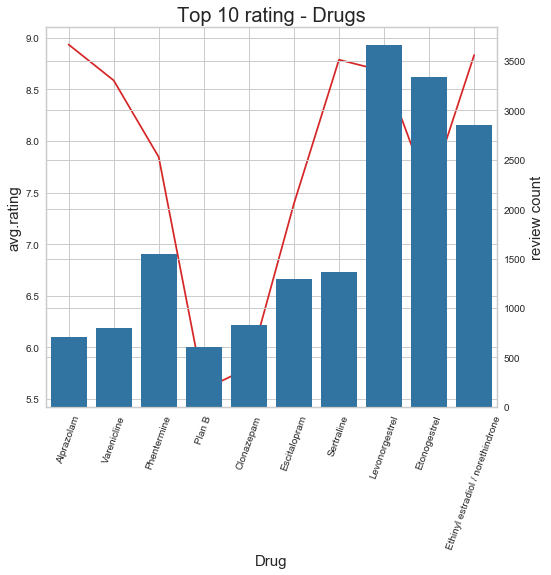

In [171]:
#plot the line chart for review count

plt.figure(figsize=(7,6))
plt.xticks(rotation=70)
color1 = 'tab:red'
plt.tight_layout()
plt_rating = sns.lineplot(x='drugname', y='rating_x', data = top_10_drugs_avg,color=color1)
plt.xlabel("Drug", size=15)
plt.ylabel("avg.rating", size=15)
plt.title("Top 10 rating - Drugs",size=20)

#line chart for avg ratings for top 10 drugs

ax2 = plt_rating.twinx()
color = 'tab:blue'
#line plot creation
ax2.set_ylabel('Avg rating', fontsize=16)
ax2 =  sns.barplot(x='drugname', y='rating_y', data = top_10_drugs_avg, color=color)
plt.ylabel("review count", size=15)
#show plot
plt.show()



##### Etonogestrel drug is having highest number of review counts, review rating is low on the other hand Alprazolam drug is having highest review rating, less review count, this is an intuitive insight

### Which Drug reviews are found useful?

In [172]:
##Look at the top 10 drugs which are having highest useful counts 
top_10_drugs_usefulcount=top_10_drugs.groupby(['drugname']).sum()['usefulcount'].reset_index().sort_values(by='usefulcount', ascending=False)
top_10_drugs_count_avgrating=top_10_drugs.groupby(['drugname']).mean()['rating'].reset_index().sort_values(by='rating', ascending=False)
drugs_count_avgrating=pd.merge(top_10_drugs_usefulcount,top_10_drugs_count_avgrating,how='inner', left_on=['drugname'], right_on = ['drugname'])
drugs_count_avgrating=drugs_count_avgrating.sort_values(by='usefulcount', ascending=False)

In [173]:
drugs_count_avgrating.head(10)

,drugname,usefulcount,rating
0,Sertraline,58154,7.497794
1,Escitalopram,52280,7.843653
2,Phentermine,46494,8.786131
3,Levonorgestrel,36769,7.391031
4,Clonazepam,32339,8.586041
5,Alprazolam,29826,8.933144
6,Etonogestrel,21917,5.802458
7,Ethinyl estradiol / norethindrone,21510,5.591930
8,Varenicline,15184,8.831234
9,Plan B,7322,8.674917


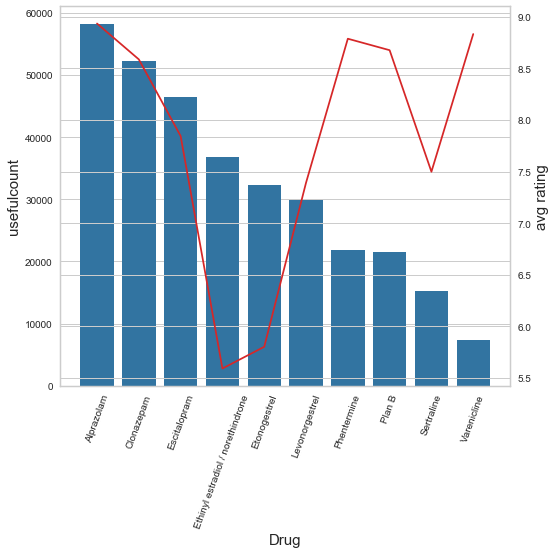

In [174]:
drugname_count = list(drugs_count_avgrating.drugname)
drug_usefulcount = list(drugs_count_avgrating.usefulcount)
plt.figure(figsize=(7,6))
plt.xticks(rotation=70)
plt.tight_layout()
color1 = 'tab:blue'
plt_rating = sns.barplot(x='drugname', y='usefulcount', data = drugs_count_avgrating, color=color1)
plt.xlabel("Drug", size=15)
plt.ylabel("usefulcount", size=15)
#plt.title("Top 10 drugs useful reviews and avg.ratings",size=20)

#line chart for avg ratings for top 10 drugs

ax2 = plt_rating.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Avg rating', fontsize=16)
ax2 = sns.lineplot(x='drugname', y='rating', data = drugs_count_avgrating, color=color)
plt.ylabel("avg rating", size=15)
#show plot
plt.show()


##### Intersting Insight : People are found some of the drug reviews are useful eventhough thier avg.review ratings are less.As we see,"Sertaline" drug reviews are found useful eventhough it has avg.review rating between 7-7.5 .But this scnerio is different for the drugs which are having highest avg.review ratings ex:Alprazolam

#### What are the Top 10 conditions in the dataset?

Text(0.5, 1, 'Top 10 Conditions')

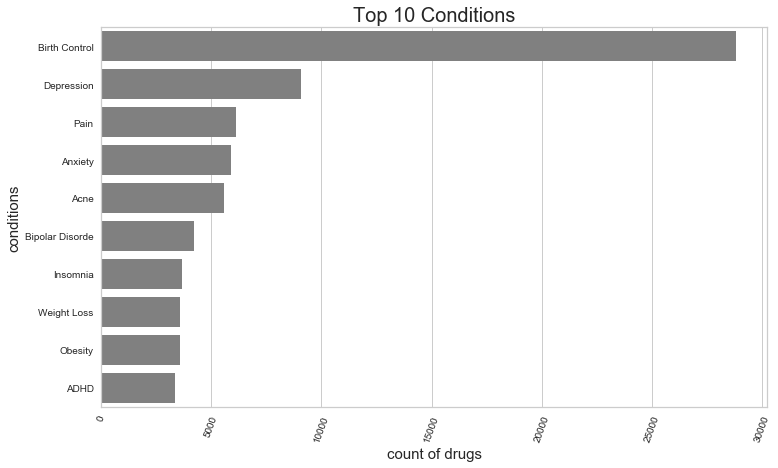

In [175]:
## Find out top 10 conditions 
df_condition=df_drug_review.groupby(['condition']).count()['rating'].reset_index().sort_values(by='rating',ascending=False)
df_condition=df_condition[0:10]
df_condition

## Plot top 10 conditions 
plt.figure(figsize=(10,6))
plt.xticks(rotation=70)
plt.tight_layout()
chart=sns.barplot(x="rating", y="condition", 
            data=df_condition,order=df_condition.sort_values('rating',ascending = False).condition,color='grey')
plt.xlabel("count of drugs", size=15)
plt.ylabel("conditions", size=15)
plt.title("Top 10 Conditions",size=20)

##### Birth Control,Depression and Pain are the top 3 health conditions out of top 10. 

#### What is the avg drug review rating and number of drugs available for each top 10 health conditions?

In [176]:
df_drug_condition=df_drug_review.groupby(['condition'])['drugname'].nunique().reset_index()



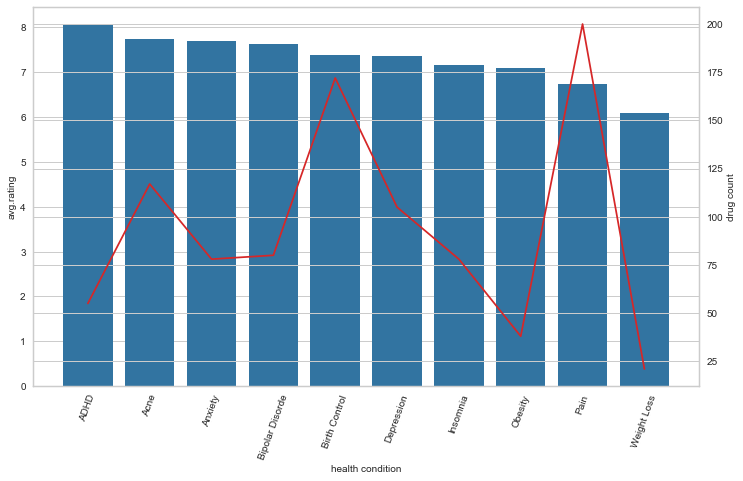

In [177]:


## Find out top 10 conditions and avg drug ratings for these conditions
df_condition_avgrating=df_drug_review.groupby(['condition']).mean()['rating'].reset_index().sort_values(by='rating',ascending=False)
df_condition_avgrating=pd.merge(df_condition_avgrating,df_condition,how='inner', left_on=['condition'], right_on = ['condition'])


##find the drug counts for each condition

condition_drug_count=pd.merge(df_condition,df_drug_condition,how='inner', left_on=['condition'], right_on = ['condition'])
condition_drug_count=condition_drug_count.rename(columns={"rating": "count"})
#print(condition_drug_count)

##combined avg rating and drug count

df_condition_avgrating=pd.merge(df_condition_avgrating,condition_drug_count,how='inner', left_on=['condition'], right_on = ['condition'])
df_condition_avgrating.head(10)
df_condition_avgrating.rename(columns={"rating_x":"avg_rating","rating_y":"count_y","drugname":"drug_count"},inplace=True)
## Plot top 10 conditions anf avg.review ratings
topcondition_count = list(df_condition_avgrating.condition)
condition_avgrating = list(df_condition_avgrating.avg_rating)
plt.figure(figsize=(10,6))
plt.xticks(rotation=70)
plt.tight_layout()
color = 'tab:blue'
plt_rating = sns.barplot(x='condition', y='avg_rating', data = df_condition_avgrating,color=color)
plt.xlabel("health condition", size=10)
plt.ylabel("avg.rating", size=10)
#plt.title("Top 10 conditions avgreviews and drug counts",size=20)

#line chart for avg ratings for top 10 drugs

ax2 = plt_rating.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('drug count', fontsize=14)
ax2 = sns.lineplot(x='condition', y='drug_count', data = df_condition_avgrating,color=color)
plt.ylabel("drug count", size=10)
#show plot
plt.show()




##### Intersting Insight 2: Some of the top health conditions avg review rating is high eventhough very few drugs available,ex:Weight loss,Obesity.At the same time,some health conditions are having less avg review rating but available drugs are very high example: Birth control

Text(0, 0.5, 'rating')

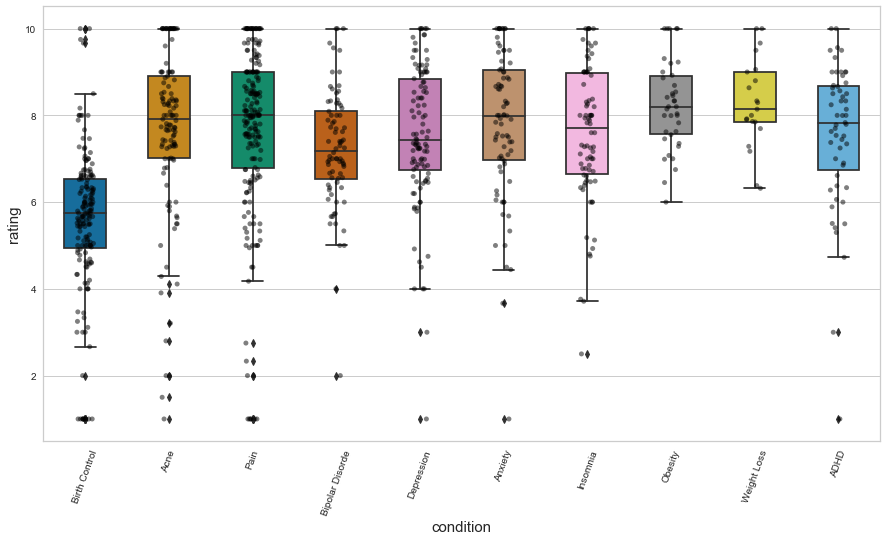

In [178]:
## Find drugs ratings for top 10 health conditions
condition_drug3_count=pd.merge(df_condition,df_drug_review,how='inner', left_on=['condition'], right_on = ['condition'])
condition_drug3_count=condition_drug3_count.rename(columns={"rating_y": "rating"})
df_condition_top3_avgrating=condition_drug3_count.groupby(['condition','drugname']).mean()['rating'].reset_index().sort_values(by='rating',ascending=False)

##Plot the ratings for all top 10 conditions and see how many drugs are having highest ratings and lowest ratings for each condition

plt.figure(figsize=(15,8))
plt.xticks(rotation=70)
plt_box=sns.boxplot(y='rating', x='condition', 
                   data=df_condition_top3_avgrating, 
                   width=0.5,
                   palette="colorblind")
plt_box=sns.stripplot(y='rating', x='condition', 
                   data=df_condition_top3_avgrating, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')
plt.xlabel("condition", size=15)
plt.ylabel("rating", size=15)
#plt.title("Top 10 Conditions - Drugs and ratings",size=20)

###### Insight 3: Birth control conditions is having around 170 drugs but small number of drugs are having highest reviews but in case of weigh all the drugs are having very good review ratings

#### What are the bottom 10 health conditions?

In [179]:
## Find out bottom 10 conditions 
df_condition_bottom=df_drug_review.groupby(['condition']).count()['rating'].reset_index().sort_values(by='rating',ascending=False)
df_condition_bottom=df_condition_bottom.tail(10)
df_condition_bottom
##find the drug counts for each condition

bottomcondition_drug_count=pd.merge(df_condition_bottom,df_drug_condition,how='inner', left_on=['condition'], right_on = ['condition'])
bottomcondition_drug_count=bottomcondition_drug_count.rename(columns={"rating": "count"})
bottomcondition_drug_count

##combined avg rating and drug count

df_condition_bottom_avgrating=pd.merge(df_condition_bottom,bottomcondition_drug_count,how='inner', left_on=['condition'], right_on = ['condition'])
df_condition_bottom_avgrating.head(10)
df_condition_bottom_avgrating.rename(columns={"rating_x":"avg_rating","rating_y":"count_y","drugname":"drug_count"},inplace=True)
df_condition_bottom_avgrating

,condition,rating,count,drug_count
0,Syringomyelia,1,1,1
1,Systemic Candidiasis,1,1,1
2,95</span> users found this comment helpful.,1,1,1
3,Cerebrovascular Insufficiency,1,1,1
4,Ramsay Hunt Syndrome,1,1,1
5,Radionuclide Myocardial Perfusion Study,1,1,1
6,Rabies Prophylaxis,1,1,1
7,Q Feve,1,1,1
8,Bartonellosis,1,1,1
9,Anti NMDA Receptor Encephalitis,1,1,1


#####  Syringomyelia,Systemic Candidiasis,Cerebrovascular Insufficiency	,Ramsay Hunt Syndrome,Radionuclide Myocardial Perfusion Study,	Rabies Prophylaxis,Q Feve,Bartonellosis,Anti NMDA Receptor Encephalitis are bottom 10 health condtions.
##### Insight 4: All bottom health conditions are having only one drug and review count available.

### Time analysis

In [180]:
# create new data frame for time analysis
drug_review_date=df_drug_review[["drugname","date", "rating","usefulcount"]]
#add month variable to the dataframe
drug_review_date['month'] = pd.DatetimeIndex(drug_review_date['date']).month
#add year variable to the dataframe
drug_review_date['year'] = pd.DatetimeIndex(drug_review_date['date']).year
#convert year variable to string for charing purpose
drug_review_date['year'] = drug_review_date['year'].apply(str)

#create data frame to see the data by year

drug_review_year=drug_review_date.groupby(['year']).count()['rating'].reset_index()

drug_review_year['year'] = drug_review_year['year'].apply(str)
drug_review_year=drug_review_year.set_index('year')
drug_review_year

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

,rating
year,
2008,5137
2009,11636
2010,8413
2011,11682
2012,10007
2013,12278
2014,12051
2015,27164
2016,34842


#### How the review rating counts changed year over year?

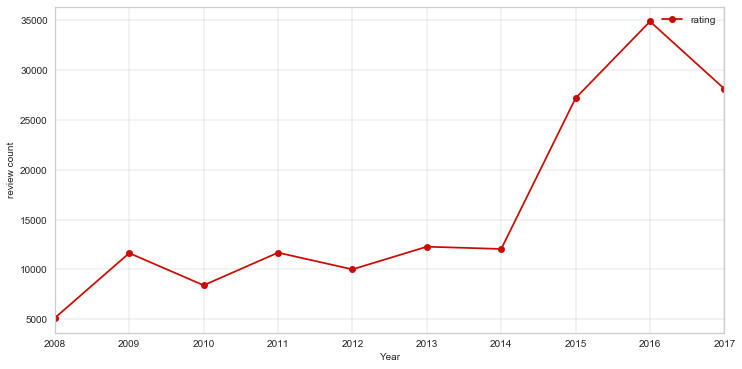

In [181]:
#plot the review count over the years
ax = drug_review_year.plot(figsize=(12,6), color='r', marker='o')
ax.set_yticklabels(pd.Series(ax.get_yticks()).map(lambda x: '{:.0f}'.format(x)))
#ax.set_title("Ratings count by year",size=20)
ax.set_xlabel("Year",size=10)
ax.set_ylabel("review count",size=10)
ax.grid(color='grey', linestyle='-', linewidth=0.2)

##### Insight 5: As we see,reviews for the drugs gradually increased from 2010 to 2014 with few fluctuations and peaked in the year of 2016 beore it sees sudden drop of review count in 2017.

#### How usefulcounts were changed year over year?

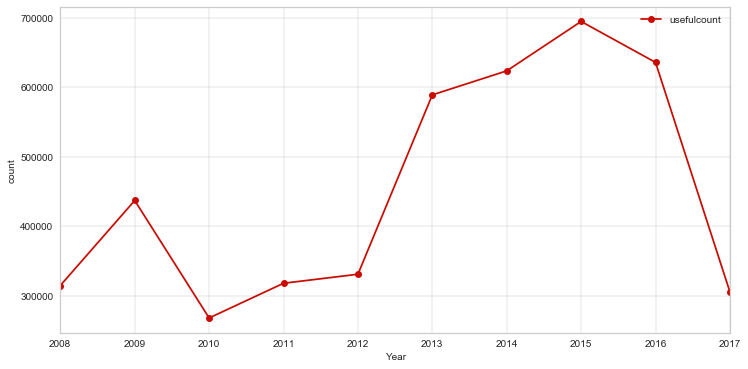

In [182]:
##create new dataframe to get the YOY useful counts
drug_usefulcount_year=drug_review_date.groupby(['year']).sum()['usefulcount'].reset_index()
drug_usefulcount_year['year'] = drug_usefulcount_year['year'].apply(str)
drug_usefulcount_year=drug_usefulcount_year.set_index('year')

#plot the useful count over the years
ax = drug_usefulcount_year.plot(figsize=(12,6), color='r', marker='o')
ax.set_yticklabels(pd.Series(ax.get_yticks()).map(lambda x: '{:.0f}'.format(x)))
#ax.set_title("usefulcount by year",size=20)
ax.set_xlabel("Year",size=10)
ax.set_ylabel("count",size=10)
ax.grid(color='grey', linestyle='-', linewidth=0.2)


##### Insight 6 : Number of people gradually increased who found drug reviews are useful from 2010 to 2014 and this count is peaked in 2015 before it sees sudden drop in subsequesnt years..Looks like,number of reviews for the drugs are decreased from 2016 so usage of drug reviews also decreased 

### How top 10 drugs ratings changed year over year?

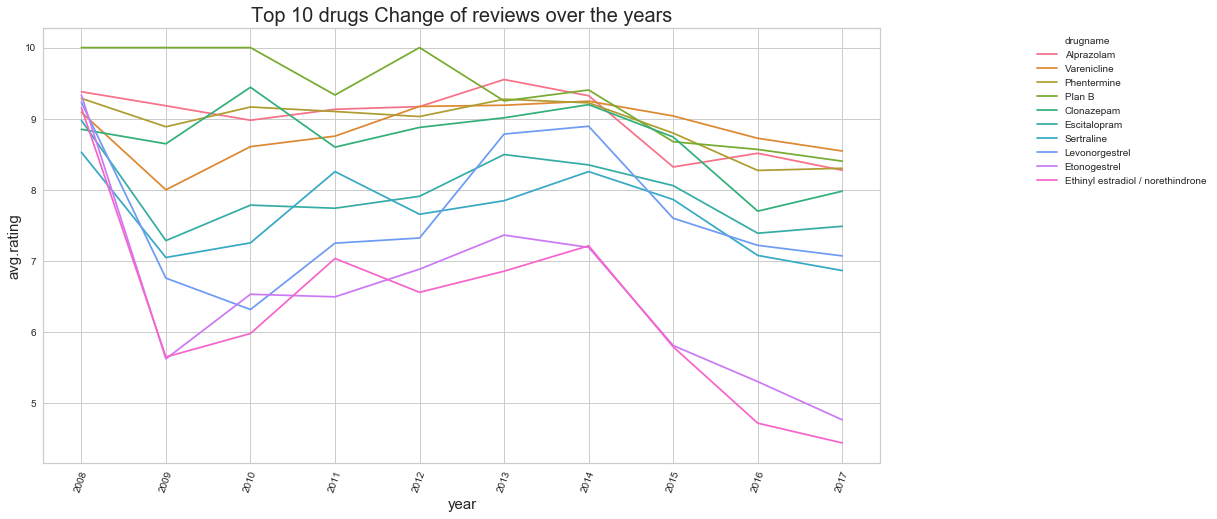

In [183]:
##create new dataframe to answer this question
drug_review_year=drug_review_date.groupby(["drugname",'year']).mean()['rating'].reset_index()
top_10_drugs_avg=top_10_drugs_avg['drugname']
drug_review_year=pd.merge(top_10_drugs_avg,drug_review_year,how='inner', left_on=['drugname'], right_on = ['drugname'])

##display sample records of this dataframe
drug_review_year.head(120)

##Plot the ratings for all top 10 conditions and see how many drugs are having highest ratings and lowest ratings for each condition

plt.figure(figsize=(15,8))
plt.xticks(rotation=70)
plt_box=sns.lineplot(data=drug_review_year, x="year", y="rating", hue="drugname")
plt.xlabel("year", size=15)
plt.ylabel("avg.rating", size=15)
plt.title("Top 10 drugs Change of reviews over the years",size=20)
plt_box.legend(loc='upper right', bbox_to_anchor=(1.4, 1))



##### Insight 7: ratings for the top 10 drugs from 2014-2015 and gradually decreased in the following years.Ex:ethinyl estrodiol,etc

#### What is the correlation between ratings and useful count?

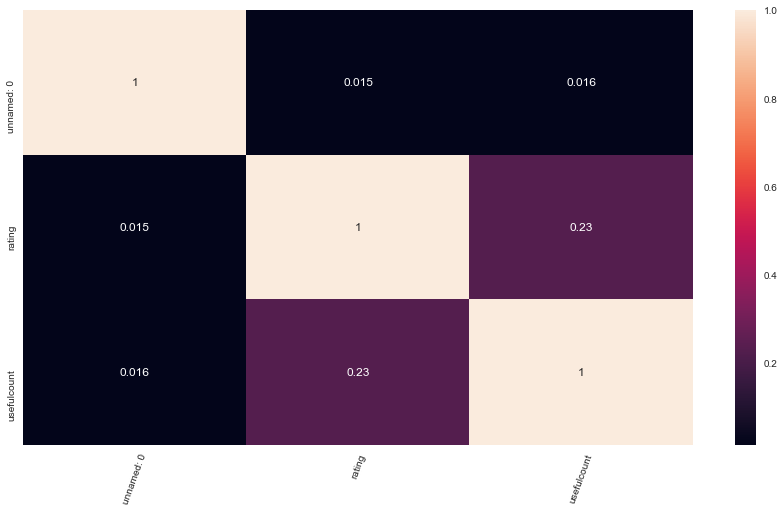

In [184]:
corr = df_drug_review.corr()
# Plot heatmap to show correlation

plt.figure(figsize=(15,8))
plt.xticks(rotation=70)
plt_box=sns.heatmap(corr, annot=True)



##### Insight 8:correlation between rating and useful count is positive but it is very small i.e 0.23..we same same insight in top drugs avg.review and useful counts.

In [185]:
!pip install wordcloud

In [186]:
from wordcloud import WordCloud

#### What are the most influential words for top 10 drugs?

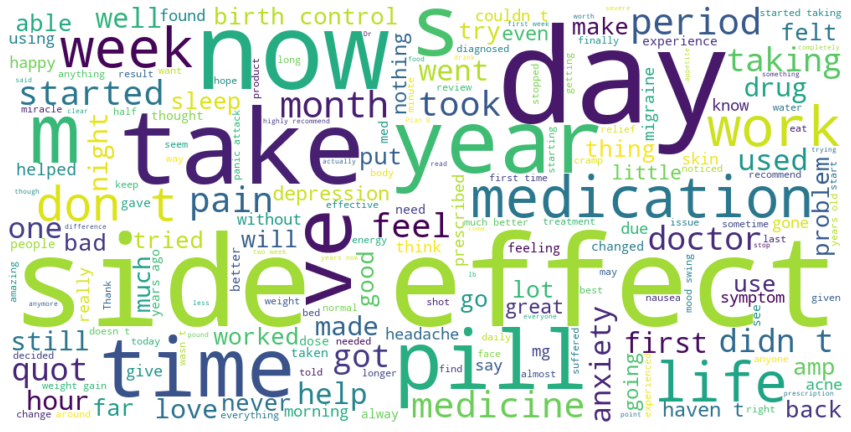

In [187]:
df_wordcloud_10 = df_drug_review.loc[df_drug_review.rating == 10, 'review']
k = (' '.join(df_wordcloud_10))

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

 Insight 9: It appears most of top 10 drug reviews shows side effects

#### What are the most influential words for top 10 health conditions?

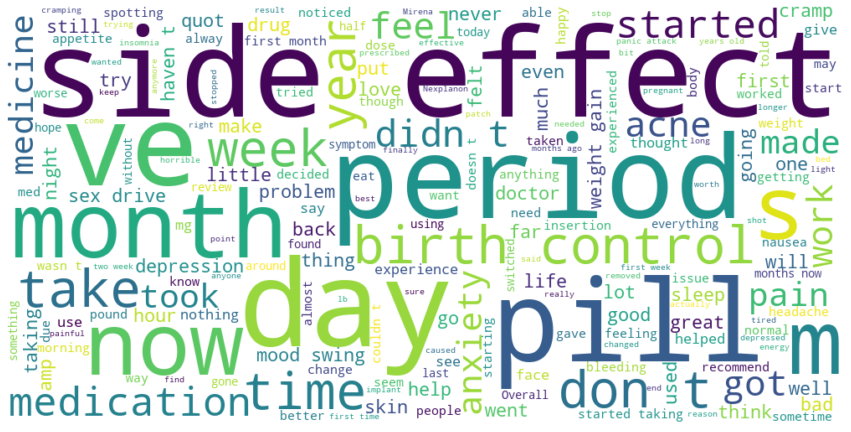

In [188]:
df_condition=pd.merge(df_condition,df_drug_review,how='inner', left_on=['condition'], right_on = ['condition'])
df_condition_review=df_condition['review']
k = (' '.join(df_condition_review))

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

##### insight 10: top 10 conditions reviews shows side effect is most occuring word.

# Sentiment Analysis

In [12]:
!pip install nltk


In [13]:
import nltk
nltk.download(['punkt','stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

####  The attribute "review" is  analyzed below in greater detail



##### Count the words in each review

In [14]:
df['wordcount']=df['review'].apply(lambda x:len(x.split()))



#### Count the characters in each review

In [15]:
df['charcount'] =df['review'].apply(lambda x:len(x))


##### Convert all the words in the review to lower case

In [16]:
 df['lowercase']= df['review'].apply(lambda x: " ".join(word.lower() for word in x.split()))
   

##### Remove all the punctuation 

In [17]:
df['punctuation'] = df['lowercase'].str.replace('[^\w\s]','')


###  Porter stemmer is installed however the approach to removed stop words and lemmatize is expected to be a better approach for text analysis

In [18]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Remove the stop words in english

In [19]:
stop_words = stopwords.words('english')

In [20]:
df['stopwords'] = df['punctuation'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))


In [21]:
#pd.Series(" ".join(df['stopwords']).split()).value_counts()[45:100]
pd.Series(" ".join(df['stopwords']).split()).value_counts()[0:45]


day           74226
i039m         71694
side          69978
taking        68233
years         61929
i039ve        61260
first         59838
pain          59660
effects       58930
take          58291
months        56681
started       56428
like          55493
get           55013
days          53468
time          51291
feel          47361
2             44971
would         44305
back          41324
pill          40974
3             40334
one           39930
weeks         39457
it039s        38813
week          37749
took          37379
also          37242
period        36779
medication    36742
doctor        36573
weight        36401
got           36145
month         34800
since         33729
life          33212
don039t       32544
still         32459
bad           32430
really        31692
much          31142
anxiety       30593
never         29855
went          29120
better        29049
dtype: int64

#### Create additional wrds that can be cleaned

In [22]:
other_stopwords = ['don039t','it039s','2','3','get','would','i039m','i039ve','4','5','10','6','two','getting','didn039t','also']

In [23]:
df['clean_review'] = df['stopwords'].apply(lambda x: " ".join(word for word in x.split() if word not in other_stopwords))


In [24]:
df.dropna().shape


(213869, 13)

### Lemmatization is performed using text blob

In [25]:
!pip install -U textblob

Requirement already up-to-date: textblob in c:\programdata\anaconda3\lib\site-packages (0.15.3)


In [26]:
#import text blob
from textblob import Word

In [27]:
df['lemmatize']= df['clean_review'].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))


### calculate the sentiment ( 'Polarity') and subjectivity of each review)

In [28]:
from textblob import TextBlob

In [29]:
df['sentiment'] = df['lemmatize'].apply(lambda x: TextBlob(x).sentiment[0])


In [30]:
df['subjectivity'] = df['lemmatize'].apply(lambda x:TextBlob(x).sentiment[1])


In [31]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,wordcount,charcount,lowercase,punctuation,stopwords,clean_review,lemmatize,sentiment,subjectivity
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,17,79,"""it has no side effect, i take it in combinati...",it has no side effect i take it in combination...,side effect take combination bystolic 5 mg fis...,side effect take combination bystolic mg fish oil,side effect take combination bystolic mg fish oil,0.000000,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141,741,"""my son is halfway through his fourth week of ...",my son is halfway through his fourth week of i...,son halfway fourth week intuniv became concern...,son halfway fourth week intuniv became concern...,son halfway fourth week intuniv became concern...,0.188021,0.482812
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134,755,"""i used to take another oral contraceptive, wh...",i used to take another oral contraceptive whic...,used take another oral contraceptive 21 pill c...,used take another oral contraceptive 21 pill c...,used take another oral contraceptive 21 pill c...,0.159790,0.367599
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89,448,"""this is my first time using any form of birth...",this is my first time using any form of birth ...,first time using form birth control i039m glad...,first time using form birth control glad went ...,first time using form birth control glad went ...,0.262500,0.618750
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,124,719,"""suboxone has completely turned my life around...",suboxone has completely turned my life around ...,suboxone completely turned life around feel he...,suboxone completely turned life around feel he...,suboxone completely turned life around feel he...,0.163333,0.384359


In [32]:
df.drop(['date','lowercase','punctuation','stopwords','clean_review'], axis = 1,inplace = True)


In [33]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,usefulCount,wordcount,charcount,lemmatize,sentiment,subjectivity
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,27,17,79,side effect take combination bystolic mg fish oil,0.000000,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,192,141,741,son halfway fourth week intuniv became concern...,0.188021,0.482812
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,17,134,755,used take another oral contraceptive 21 pill c...,0.159790,0.367599
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,10,89,448,first time using form birth control glad went ...,0.262500,0.618750
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,37,124,719,suboxone completely turned life around feel he...,0.163333,0.384359


In [ ]:
dfsent = df.sort_values(by ='sentiment')

### Create a class label based on sentiment

In [34]:
df["class_label"]=df["sentiment"].apply(lambda x: 'neutral' if x==0 else ('negative' if x<0 else 'positive'))


In [35]:
df.tail()

,Unnamed: 0,drugName,condition,review,rating,usefulCount,wordcount,charcount,lemmatize,sentiment,subjectivity,class_label
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,43,97,533,taken tamoxifen year side effect severe sweati...,-0.083333,0.20000,negative
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,11,130,763,taking lexapro escitaploprgram since february ...,0.117193,0.60355,positive
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,7,149,780,married 34 year old kid taking pill hassle dec...,-0.049126,0.55676,negative
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,20,34,200,prescribed nucynta severe neckshoulder pain ta...,0.000000,0.00000,neutral
53765,113712,Arthrotec,Sciatica,"""It works!!!""",9.0,46,2,13,work,0.000000,0.00000,neutral


### Correlation plot between sentiment and the rating

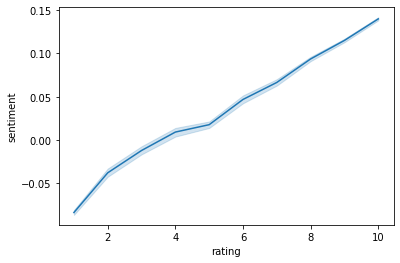

In [36]:
import seaborn as sns
plt = sns.lineplot(data=df,x='rating',y='sentiment')
plt

#### We can see that there is positive correlation, as the rating increases the sentiment is also increased.Showing the positive sentiment associated with higher rating

In [83]:
df2 = df.iloc[:,10:12]

In [84]:
df2.head()

,subjectivity,class_label
0,0.000000,neutral
1,0.482812,positive
2,0.367599,positive
3,0.618750,positive
4,0.384359,positive


In [85]:

df2.groupby('class_label').size()


class_label
negative     70105
neutral      11661
positive    133297
dtype: int64

In [ ]:
df2.groupby('class_label').count().plot.bar()

#### negative reviews account to 32 %,positive 61.9% and neutral reviews to 5 % of the data

### Calculate term frequency and inverse document frequency of the review that is lemmatized using tfidfVectorizer

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [90]:
v = TfidfVectorizer()
attribute = v.fit_transform(df['lemmatize'])
claslabel = df.class_label
#print(claslabel)

In [ ]:
attribute

In [ ]:
df.head

### Machine learning to predict sentiment based on review

##### 1.Logistic Regression

In [92]:
x_train,x_test,y_train,y_test = train_test_split(attribute,claslabel,test_size=0.30,random_state=0)

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


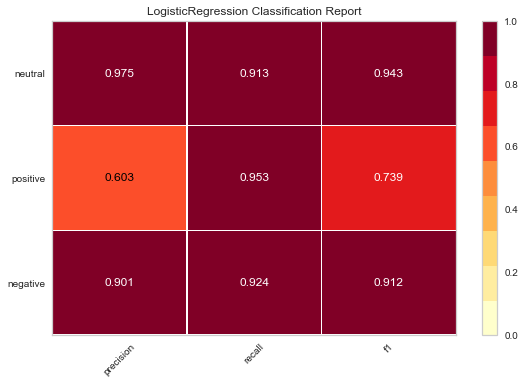

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


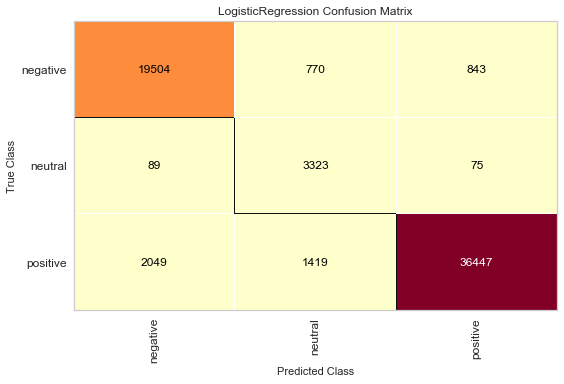

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


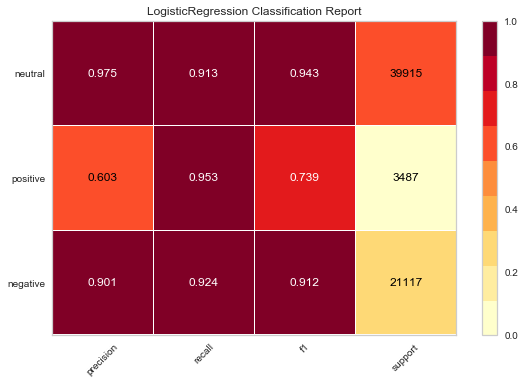

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


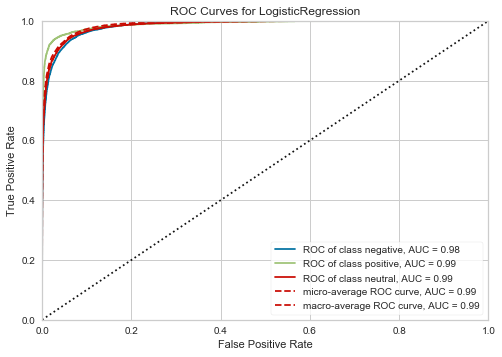

In [97]:
##Build logistic regression
from yellowbrick.classifier import ConfusionMatrix
model = LogisticRegression(multi_class='multinomial',solver ='newton-cg',class_weight = "balanced")
#visualizer = ROCAUC(model, classes=['negative','positive','neutral'])
visualizer = ClassificationReport(model, classes=['negative','positive','neutral'])


#confusion matrix
log_cm = ConfusionMatrix(model)
log_cm.fit(x_train, y_train)        # Fit the training data to the visualizer
log_cm.score(x_test, y_test)        # Evaluate the model on the test data
log_cm.show()

##classification report

log_cr = ClassificationReport(model, classes=['negative','positive','neutral'], support=True)
log_cr.fit(x_train, y_train)        # Fit the training data to the visualizer
log_cr.score(x_test, y_test)        # Evaluate the model on the test data
log_cr.show()

##ROC curve

ROC = ROCAUC(model, classes=['negative','positive','neutral'])
ROC.fit(x_train, y_train)        # Fit the training data to the visualizer
ROC.score(x_test, y_test)        # Evaluate the model on the test data
ROC.show()



In [149]:
y_pred_lr=model.predict(x_test)
print("Accuracy_logreg:",metrics.accuracy_score(y_test,y_pred_lr))

Accuracy_logreg: 0.9187061175777678


#### 2. Multinomial Naive Bayes

In [95]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(x_train, y_train)
y_predmnb = mnb.predict(x_test)


C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


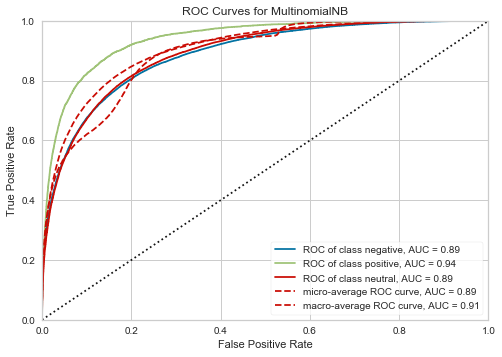

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


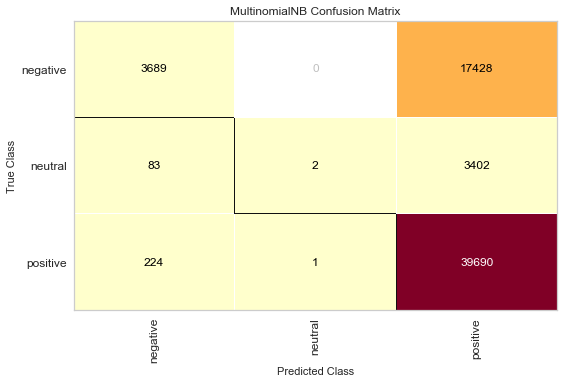

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


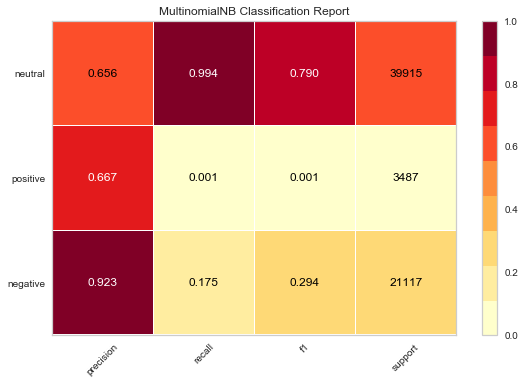

In [96]:
mnb_roc = ROCAUC(mnb, classes=['negative','positive','neutral'])
#ROC
mnb_roc.fit(x_train, y_train)        # Fit the training data to the visualizer
mnb_roc.score(x_train, y_train)        # Evaluate the model on the test data
mnb_roc.show()

#confusion matrix
mnb_cm = ConfusionMatrix(mnb)
mnb_cm.fit(x_train, y_train)        # Fit the training data to the visualizer
mnb_cm.score(x_test, y_test)        # Evaluate the model on the test data
mnb_cm.show()

##classification report

mnb_cr = ClassificationReport(mnb, classes=['negative','positive','neutral'], support=True)
mnb_cr.fit(x_train, y_train)        # Fit the training data to the visualizer
mnb_cr.score(x_test, y_test)        # Evaluate the model on the test data
mnb_cr.show()


In [153]:
#y_pred_lr=model.predict(x_test)
print("Accuracy_navibayes:",metrics.accuracy_score(y_test,y_predmnb))

Accuracy_navibayes: 0.6723755792867218


#### 3. Decision Tree Classifier

In [99]:
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt = dt.fit(x_train,y_train)

#Predict the response for test dataset
y_predtree = dt.predict(x_test)
print("Accuracy:tree",metrics.accuracy_score(y_test, y_predtree))

Accuracy:tree 0.9020288597157426


C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


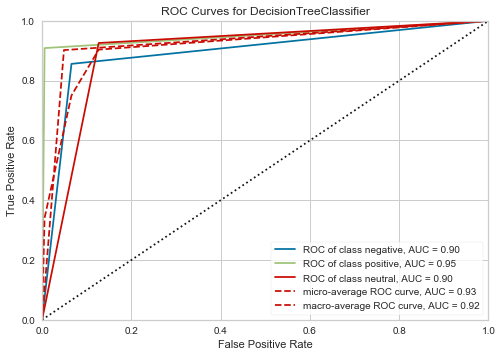

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


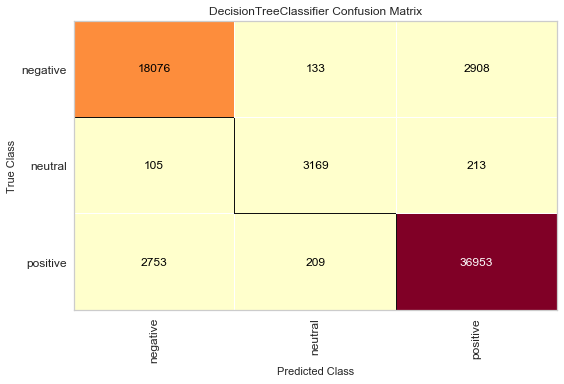

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


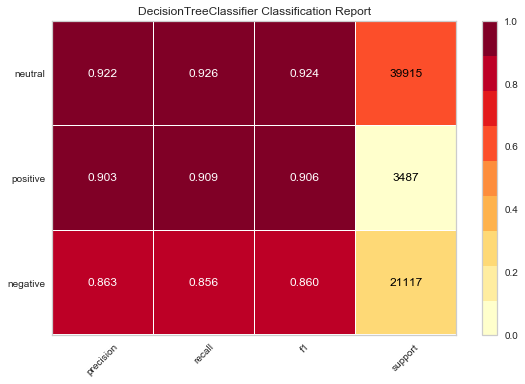

In [100]:

dt_roc = ROCAUC(dt, classes=['negative','positive','neutral'])
dt_roc.fit(x_train, y_train)        # Fit the training data to the visualizer
dt_roc.score(x_test, y_test)        # Evaluate the model on the test data
dt_roc.show()

#confusion matrix
dt_cm = ConfusionMatrix(dt)
dt_cm.fit(x_train, y_train)        # Fit the training data to the visualizer
dt_cm.score(x_test, y_test)        # Evaluate the model on the test data
dt_cm.show()

##classification report

dt_cr = ClassificationReport(dt, classes=['negative','positive','neutral'], support=True)
dt_cr.fit(x_train, y_train)        # Fit the training data to the visualizer
dt_cr.score(x_test, y_test)        # Evaluate the model on the test data
dt_cr.show()

In [154]:

print("Accuracy_Decisiontree:",metrics.accuracy_score(y_test,y_predtree))

Accuracy_Decisiontree: 0.9020288597157426


#### 4. Random Forest

In [102]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


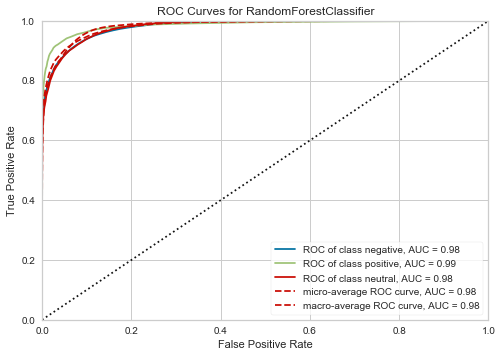

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


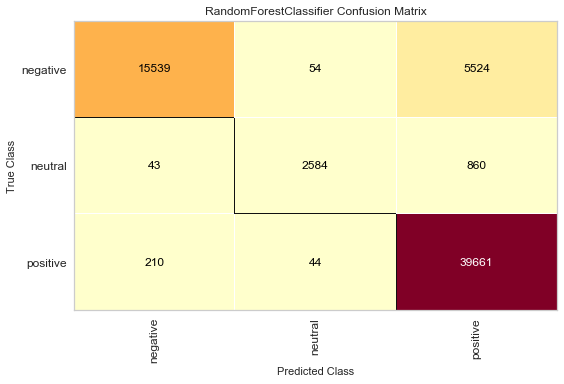

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


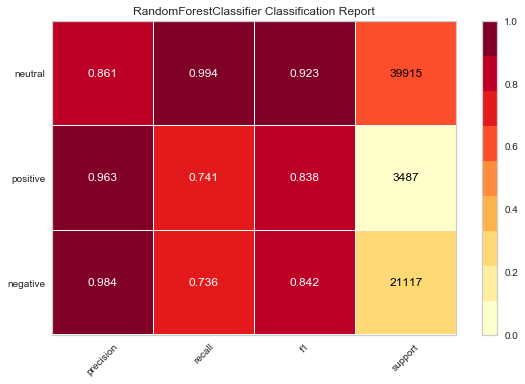

In [106]:

rf_roc = ROCAUC(rf, classes=['negative','positive','neutral'])
rf_roc.fit(x_train, y_train)        # Fit the training data to the visualizer
rf_roc.score(x_test, y_test)        # Evaluate the model on the test data
rf_roc.show()

#confusion matrix
rf_cm = ConfusionMatrix(rf)
rf_cm.fit(x_train, y_train)        # Fit the training data to the visualizer
rf_cm.score(x_test, y_test)        # Evaluate the model on the test data
rf_cm.show()

##classification report

rf_cr = ClassificationReport(rf, classes=['negative','positive','neutral'], support=True)
rf_cr.fit(x_train, y_train)        # Fit the training data to the visualizer
rf_cr.score(x_test, y_test)        # Evaluate the model on the test data
rf_cr.show()


In [155]:
y_pred_rf=rf.predict(x_test)
print("Accuracy_randomforsest:",metrics.accuracy_score(y_test,y_pred_rf))

Accuracy_randomforsest: 0.8956121452595359


#### 5. Support Vector Machines

In [107]:
from sklearn import svm
clf = svm.SVC(kernel='linear',probability = True) # Linear Kernel

#Train the model using the training sets
svm = clf.fit(x_train, y_train)



In [108]:
#Predict the response for test dataset
y_pred_svm = clf.predict(x_test)

In [117]:
print("Accuracy_svm:",metrics.accuracy_score(y_test,y_pred_svm))

Accuracy_svm: 0.9501697174475736


C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


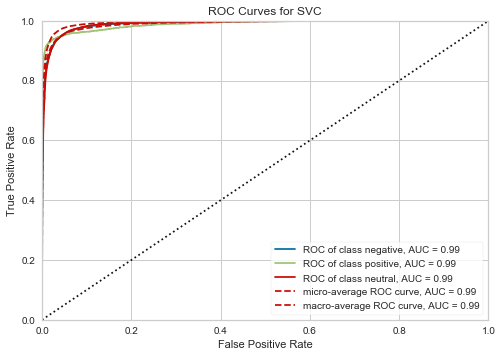

In [110]:
svm_roc = ROCAUC(svm, classes=['negative','positive','neutral'])
svm_roc.fit(x_train, y_train)        # Fit the training data to the visualizer
svm_roc.score(x_test, y_test)        # Evaluate the model on the test data
svm_roc.show()

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


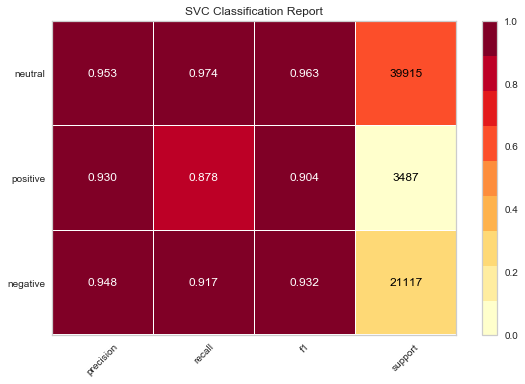

In [115]:
svm_cr = ClassificationReport(svm, classes=['negative','positive','neutral'], support=True)
svm_cr.score(x_test, y_test)        # Evaluate the model on the test data
svm_cr.show()

C:\Users\adari\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


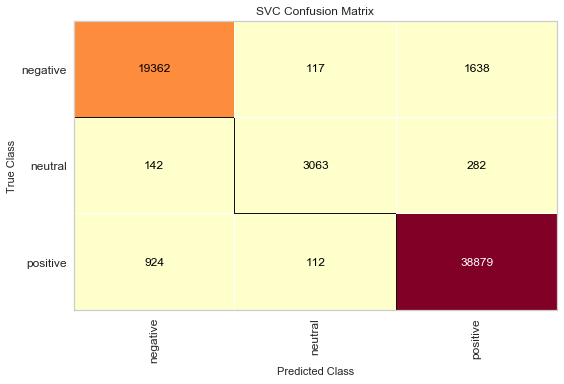

In [118]:


#confusion matrix
svm_cm = ConfusionMatrix(svm)
svm_cm.fit(x_train, y_train)        # Fit the training data to the visualizer
svm_cm.score(x_test, y_test)        # Evaluate the model on the test data
svm_cm.show()




### Feature importance

In [136]:
from yellowbrick.model_selection import FeatureImportances

In [139]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                            columns=['importance']).sort_values('importance', ascending=False)

In [141]:
feature_importances.head(5)

,importance
16449,0.044340
39901,0.042791
37404,0.030712
84651,0.028394
37083,0.027371


In [140]:
feature_imp_rf = pd.DataFrame(rf.feature_importances_,
                                            columns=['importance']).sort_values('importance', ascending=False)

In [143]:
feature_imp_rf.head(6)

,importance
16449,0.014443
39901,0.011668
37404,0.011634
84651,0.010440
37083,0.008879
76637,0.008822


In [145]:
wordtf = pd.DataFrame(v.get_feature_names(),columns = ['wrd'])

In [147]:
wordtf.iloc[[16449,39901,37404,84651,37083,76637],]

,wrd
16449,bad
39901,horrible
37404,great
84651,worst
37083,good
76637,terrible
